# Haystack Framework with Pipelines

Haystack is an open-source framework by deepset that allows developers to orchestrate LLM applications made up of different components like models, vector DBs, file converters, and countless other modules. Haystack provides pipelines and Agents, helpful in designing LLM applications for various use cases including search, question answering, and conversational AI.

The example uses `DocumentStore` and `Pipeline`.

The DocumentStore  is used to cache the documents needed to retrieve answers to your questions. This example, uses the `InMemoryDocumentStore`.

It also uses the  BM25 Retriever method for text retrieval.

## Setup installation


In [1]:
%%bash

pip install --upgrade pip
pip install farm-haystack[colab,inference]

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 29.1 MB/s eta 0:00:00
  Attempting uninstall: pip
    Found existing installation: pip 23.1.2
    Uninstalling pip-23.1.2:
      Successfully uninstalled pip-23.1.2
  Obtaining dependency information for farm-haystack[colab,inference] from https://files.pythonhosted.org/packages/e1/21/5b8e501524275bbb4345cd66499310e035ff953e4192af1aaa007edf5b46/farm_haystack-1.21.2-py3-none-any.whl.metadata
  Obtaining dependency information for events from https://files.pythonhosted.org/packages/25/ed/e47dec0626edd468c84c04d97769e7ab4ea6457b7f54dcb3f72b17fcd876/Events-0.5-py3-none-any.whl.metadata
  Obtaining dependency information for httpx from https://files.pythonhosted.org/packages/33/0d/d9ce469af019741c8999711d36b270ff992ceb1a0293f73f9f34fdf131e9/httpx-0.25.0-py3-none-any.whl.metadata
  Obtaining dependency information for posthog from https://files.pythonhosted.org/packages/a7/73/35758818228c70348be4c3c66a76653c62e894e0e3c3461453c5341ca926

## Config Logging

Setup the log level for messages

In [2]:
import logging

logging.basicConfig(format="%(levelname)s - %(name)s -  %(message)s", level=logging.WARNING)
logging.getLogger("haystack").setLevel(logging.INFO)

## DocumentStore


Initialize the `InMemoryDocumentStore`.

In [3]:
from haystack.document_stores import InMemoryDocumentStore

document_store = InMemoryDocumentStore(use_bm25=True)

INFO:haystack.telemetry:Haystack sends anonymous usage data to understand the actual usage and steer dev efforts towards features that are most meaningful to users. You can opt-out at anytime by manually setting the environment variable HAYSTACK_TELEMETRY_ENABLED as described for different operating systems in the [documentation page](https://docs.haystack.deepset.ai/docs/telemetry#how-can-i-opt-out). More information at [Telemetry](https://docs.haystack.deepset.ai/docs/telemetry).
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


## Fetching and Writing Documents

Retrive text files (Countries & Capital information) that will be indexed into the DocumentStore:

In [4]:
from haystack.utils import fetch_archive_from_http, convert_files_to_docs, clean_wiki_text

# Download and prepare data - 517 Wikipedia articles for Game of Thrones
doc_dir = "data/Cities"
s3_url = "https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/article_txt_countries_and_capitals.zip"
fetch_archive_from_http(url=s3_url, output_dir=doc_dir)

# convert files to dicts containing documents that can be indexed to our datastore
got_docs = convert_files_to_docs(dir_path=doc_dir, clean_func=clean_wiki_text, split_paragraphs=True)
document_store.delete_documents()
document_store.write_documents(got_docs)

INFO:haystack.utils.import_utils:Fetching from https://s3.eu-central-1.amazonaws.com/deepset.ai-farm-qa/datasets/documents/article_txt_countries_and_capitals.zip to 'data/Cities'
INFO:haystack.utils.preprocessing:Converting data/Cities/article_txt_countries_and_capitals/239_Hanoi.txt
INFO:haystack.utils.preprocessing:Converting data/Cities/article_txt_countries_and_capitals/151_Stockholm.txt
INFO:haystack.utils.preprocessing:Converting data/Cities/article_txt_countries_and_capitals/90_Benin.txt
INFO:haystack.utils.preprocessing:Converting data/Cities/article_txt_countries_and_capitals/184_Samoa.txt
INFO:haystack.utils.preprocessing:Converting data/Cities/article_txt_countries_and_capitals/62_Mogadishu.txt
INFO:haystack.utils.preprocessing:Converting data/Cities/article_txt_countries_and_capitals/180_South_Korea.txt
INFO:haystack.utils.preprocessing:Converting data/Cities/article_txt_countries_and_capitals/149_Ghazni_under_the_Ghaznavids.txt
INFO:haystack.utils.preprocessing:Converting 

In [5]:
from haystack.nodes import BM25Retriever, EmbeddingRetriever, FARMReader

bm25_retriever = BM25Retriever()

from haystack.pipelines import DocumentSearchPipeline
from haystack.utils import print_documents

p_retrieval = DocumentSearchPipeline(bm25_retriever)


## Initializing Core Components

Here we initialize the core components that we will be gluing together using the `Pipeline` class.
Initialize a `BM25Retriever`, an `EmbeddingRetriever`, and a `FARMReader`.
You can combine these components to create a classic Retriever-Reader pipeline that is designed
to perform Open Domain Question Answering.

In [6]:
from haystack.nodes import BM25Retriever, EmbeddingRetriever, FARMReader

# Initialize Sparse Retriever
bm25_retriever = BM25Retriever(document_store=document_store)

# Initialize embedding Retriever
embedding_retriever = EmbeddingRetriever(
    document_store=document_store, embedding_model="sentence-transformers/multi-qa-mpnet-base-dot-v1"
)
document_store.update_embeddings(embedding_retriever, update_existing_embeddings=False)

# Initialize Reader
reader = FARMReader(model_name_or_path="deepset/roberta-base-squad2")

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


(…)e/main/config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

INFO:haystack.nodes.retriever.dense:Init retriever using embeddings of model sentence-transformers/multi-qa-mpnet-base-dot-v1


(…)70bdf8fca0ca826b6b5d16ebc/.gitattributes:   0%|          | 0.00/737 [00:00<?, ?B/s]

(…)ca0ca826b6b5d16ebc/1_Pooling/config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

(…)abd4f70bdf8fca0ca826b6b5d16ebc/README.md:   0%|          | 0.00/8.65k [00:00<?, ?B/s]

(…)d4f70bdf8fca0ca826b6b5d16ebc/config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

(…)d16ebc/config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

(…)bdf8fca0ca826b6b5d16ebc/data_config.json:   0%|          | 0.00/25.5k [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/438M [00:00<?, ?B/s]

(…)a826b6b5d16ebc/sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

(…)0ca826b6b5d16ebc/special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

(…)70bdf8fca0ca826b6b5d16ebc/tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

(…)ca0ca826b6b5d16ebc/tokenizer_config.json:   0%|          | 0.00/363 [00:00<?, ?B/s]

(…)0bdf8fca0ca826b6b5d16ebc/train_script.py:   0%|          | 0.00/13.9k [00:00<?, ?B/s]

(…)abd4f70bdf8fca0ca826b6b5d16ebc/vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

(…)4f70bdf8fca0ca826b6b5d16ebc/modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
INFO:haystack.document_stores.memory:Updating embeddings for 0 docs ...
Updating Embedding:   0%|          | 0/14401 [00:00<?, ? docs/s]

Batches:   0%|          | 0/313 [00:00<?, ?it/s]

Documents Processed:  69%|██████▉   | 10000/14401 [03:53<01:42, 42.89 docs/s]

Batches:   0%|          | 0/138 [00:00<?, ?it/s]

Documents Processed: 20000 docs [05:29, 60.65 docs/s]
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1
INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


(…)rta-base-squad2/resolve/main/config.json:   0%|          | 0.00/571 [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model: * LOADING MODEL: 'deepset/roberta-base-squad2' (Roberta)


model.safetensors:   0%|          | 0.00/496M [00:00<?, ?B/s]

INFO:haystack.modeling.model.language_model:Auto-detected model language: english
INFO:haystack.modeling.model.language_model:Loaded 'deepset/roberta-base-squad2' (Roberta model) from model hub.


(…)quad2/resolve/main/tokenizer_config.json:   0%|          | 0.00/79.0 [00:00<?, ?B/s]

(…)erta-base-squad2/resolve/main/vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

(…)erta-base-squad2/resolve/main/merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

(…)ad2/resolve/main/special_tokens_map.json:   0%|          | 0.00/772 [00:00<?, ?B/s]

INFO:haystack.modeling.utils:Using devices: CUDA:0 - Number of GPUs: 1


## Use Prebuilt Pipelines

Haystack features a number of prebuilt pipelines the most common one use  is via `ExtractiveQAPipeline` to create a `Reader` and BM25 Text `Retriever`


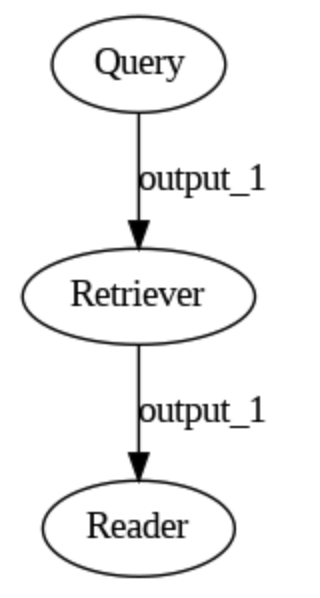

In [7]:
from haystack.pipelines import ExtractiveQAPipeline
from haystack.utils import print_answers

p_extractive_premade = ExtractiveQAPipeline(reader=reader, retriever=bm25_retriever)
res = p_extractive_premade.run(
    query="What are the World Heritage Sites in London?", params={"Retriever": {"top_k": 10}, "Reader": {"top_k": 5}}
)
print_answers(res, details="minimum")

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.40 Batches/s]

'Query: What are the World Heritage Sites in London?'
'Answers:'
[   {   'answer': 'the Tower of London; Kew Gardens; the Palace of '
                  'Westminster, along with  Westminster Abbey, and St '
                  "Margaret's Church",
        'context': ' Heritage Sites: the Tower of London; Kew Gardens; the '
                   'Palace of Westminster, along with  Westminster Abbey, and '
                   "St Margaret's Church; and the histori"},
    {   'answer': 'Luang Prabang and Vat Phou',
        'context': 'stination" designation for 2013 for architecture and '
                   'history.\n'
                   'Luang Prabang and Vat Phou are both UNESCO World Heritage '
                   'sites. Major festivals include'},
    {   'answer': 'Imperial College London in natural and applied sciences, '
                  'the London School of Economics in social sciences, and the '
                  'comprehensive University College London',
        'context': ' Imperial

If you want to just do the retrieval step, you can use a DocumentSearchPipeline:

In [8]:
from haystack.pipelines import DocumentSearchPipeline
from haystack.utils import print_documents

p_retrieval = DocumentSearchPipeline(embedding_retriever)
res = p_retrieval.run(query="What are the World Heritage Sites in London?", params={"Retriever": {"top_k": 10}})
print_documents(res, max_text_len=200)

Batches:   0%|          | 0/1 [00:00<?, ?it/s]


Query: What are the World Heritage Sites in London?

{   'content': '\n==See also==\n*List of World Heritage in Danger',
    'name': '115_Damascus.txt'}

{   'content': "'''London''' is the capital and largest city of England and "
               'the United Kingdom. It stands on the River Thames in '
               'south-east England at the head of a  estuary down to the North '
               'Sea, and has been a majo...',
    'name': '44_London.txt'}

{   'content': '\n'
               '== Culture ==\n'
               'Attractions in the city include a clocktower modelled on '
               'Little Ben in London, the courthouse, the Botanical Gardens, '
               'the National Museum of History, the Natural History Museum and '
               'the ...',
    'name': '98_Victoria__Seychelles.txt'}

{   'content': '\n== See also ==\n* List of World Heritage Sites in Spain',
    'name': '175_Spain.txt'}

{   'content': '\n'
               '=== Heritage ===\n'
               "Slo

Haystack features prebuilt pipelines to do:
- document search (DocumentSearchPipeline),
- document search with summarization (SearchSummarizationPipeline)
- FAQ style QA (FAQPipeline)
- translated search (TranslationWrapperPipeline)



## Custom Extractive QA Pipeline

Use the ExtractiveQAPipeline function to create a custome pipeline

In [9]:
from haystack.pipelines import Pipeline

# Custom built extractive QA pipeline
p_extractive = Pipeline()
p_extractive.add_node(component=bm25_retriever, name="Retriever", inputs=["Query"])
p_extractive.add_node(component=reader, name="Reader", inputs=["Retriever"])

# Now we can run it
res = p_extractive.run(query="What are the World Heritage Sites in London?", params={"Retriever": {"top_k": 10}})
print_answers(res, details="minimum")

# Uncomment the following to generate the pipeline image
# p_extractive.draw("pipeline_extractive.png")

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.42 Batches/s]

'Query: What are the World Heritage Sites in London?'
'Answers:'
[   {   'answer': 'the Tower of London; Kew Gardens; the Palace of '
                  'Westminster, along with  Westminster Abbey, and St '
                  "Margaret's Church",
        'context': ' Heritage Sites: the Tower of London; Kew Gardens; the '
                   'Palace of Westminster, along with  Westminster Abbey, and '
                   "St Margaret's Church; and the histori"},
    {   'answer': 'Luang Prabang and Vat Phou',
        'context': 'stination" designation for 2013 for architecture and '
                   'history.\n'
                   'Luang Prabang and Vat Phou are both UNESCO World Heritage '
                   'sites. Major festivals include'},
    {   'answer': 'Imperial College London in natural and applied sciences, '
                  'the London School of Economics in social sciences, and the '
                  'comprehensive University College London',
        'context': ' Imperial

## Combining Retrievers Using a Custom Pipeline

Pipelines can be created and merged, the example uses the  `EmbeddingRetriever` with the keyword based `BM25Retriever`.

Using the `JoinDocuments` node to merge the predictions from each retriever:

![image](https://github.com/deepset-ai/haystack/blob/main/docs/img/tutorial11_custompipelines_pipeline_ensemble.png?raw=true)



In [10]:
from haystack.nodes import JoinDocuments

# Create ensembled pipeline
p_ensemble = Pipeline()
p_ensemble.add_node(component=bm25_retriever, name="BM25Retriever", inputs=["Query"])
p_ensemble.add_node(component=embedding_retriever, name="EmbeddingRetriever", inputs=["Query"])
p_ensemble.add_node(
    component=JoinDocuments(join_mode="concatenate"), name="JoinResults", inputs=["BM25Retriever", "EmbeddingRetriever"]
)
p_ensemble.add_node(component=reader, name="Reader", inputs=["JoinResults"])

# Uncomment the following to generate the pipeline image
# p_ensemble.draw("pipeline_ensemble.png")

# Run pipeline
res = p_ensemble.run(
    query="What are the World Heritage Sites in London?", params={"EmbeddingRetriever": {"top_k": 5}, "BM25Retriever": {"top_k": 5}}
)
print_answers(res, details="minimum")

Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.78 Batches/s]

'Query: What are the World Heritage Sites in London?'
'Answers:'
[   {   'answer': 'the Tower of London; Kew Gardens; the Palace of '
                  'Westminster, along with  Westminster Abbey, and St '
                  "Margaret's Church",
        'context': ' Heritage Sites: the Tower of London; Kew Gardens; the '
                   'Palace of Westminster, along with  Westminster Abbey, and '
                   "St Margaret's Church; and the histori"},
    {   'answer': 'National Museum of History, the Natural History Museum and '
                  'the Sir Selwyn Selwyn-Clarke Market',
        'context': ' the Botanical Gardens, the National Museum of History, '
                   'the Natural History Museum and the Sir Selwyn '
                   'Selwyn-Clarke Market. Victoria Market and the br'},
    {   'answer': 'Imperial College London in natural and applied sciences, '
                  'the London School of Economics in social sciences, and the '
                  'compr


# Custom Class
 Create a class that will act as a customised node and recreate the pipeline.  One one retriever (BM25Retriever or EmdeddedRetriever) will be run for a request as defined in the class `CustomQueryClassifier`

In [11]:
from haystack import BaseComponent
from typing import Optional, List

# This will define the
class CustomQueryClassifier(BaseComponent):
    outgoing_edges = 2

    def run(self, query: str):
        if "?" in query:
            return {}, "output_2"
        else:
            return {}, "output_1"

    def run_batch(self, queries: List[str]):
        split = {"output_1": {"queries": []}, "output_2": {"queries": []}}
        for query in queries:
            if "?" in query:
                split["output_2"]["queries"].append(query)
            else:
                split["output_1"]["queries"].append(query)

        return split, "split"


# Here we build the pipeline
p_classifier = Pipeline()
p_classifier.add_node(component=CustomQueryClassifier(), name="QueryClassifier", inputs=["Query"])
p_classifier.add_node(component=bm25_retriever, name="BM25Retriever", inputs=["QueryClassifier.output_1"])
p_classifier.add_node(component=embedding_retriever, name="EmbeddingRetriever", inputs=["QueryClassifier.output_2"])
p_classifier.add_node(component=reader, name="QAReader", inputs=["BM25Retriever", "EmbeddingRetriever"])


# Run only the dense retriever on the full sentence query
res_1 = p_classifier.run(query="What are the World Heritage Sites in London?")
print("Embedding Retriever Results" + "\n" + "=" * 15)
print_answers(res_1)

# Run only the sparse retriever on a keyword based query
res_2 = p_classifier.run(query="London World Hertiage")
print("BM25Retriever Results" + "\n" + "=" * 15)
print_answers(res_2)


Batches:   0%|          | 0/1 [00:00<?, ?it/s]

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  2.97 Batches/s]


Embedding Retriever Results
'Query: What are the World Heritage Sites in London?'
'Answers:'
[   <Answer {'answer': "the Tower of London; Kew Gardens; the Palace of Westminster, along with  Westminster Abbey, and St Margaret's Church", 'type': 'extractive', 'score': 0.8029680252075195, 'context': " Heritage Sites: the Tower of London; Kew Gardens; the Palace of Westminster, along with  Westminster Abbey, and St Margaret's Church; and the histori", 'offsets_in_document': [{'start': 2190, 'end': 2306}], 'offsets_in_context': [{'start': 17, 'end': 133}], 'document_ids': ['fbbc8de11d2ade5732cc2d4f656de78d'], 'meta': {'name': '44_London.txt'}}>,
    <Answer {'answer': 'National Museum of History, the Natural History Museum and the Sir Selwyn Selwyn-Clarke Market', 'type': 'extractive', 'score': 0.4115979075431824, 'context': ' the Botanical Gardens, the National Museum of History, the Natural History Museum and the Sir Selwyn Selwyn-Clarke Market. Victoria Market and the br', 'offsets_in_do

Inferencing Samples: 100%|██████████| 1/1 [00:00<00:00,  3.06 Batches/s]

BM25Retriever Results
'Query: London World Hertiage'
'Answers:'
[   <Answer {'answer': 'four World Heritage Sites', 'type': 'extractive', 'score': 0.16498687863349915, 'context': " and Moscow's, with 14,040,163 inhabitants in 2016.\nLondon has four World Heritage Sites: the Tower of London; Kew Gardens; the Palace of Westminster,", 'offsets_in_document': [{'start': 2163, 'end': 2188}], 'offsets_in_context': [{'start': 63, 'end': 88}], 'document_ids': ['fbbc8de11d2ade5732cc2d4f656de78d'], 'meta': {'name': '44_London.txt'}}>,
    <Answer {'answer': 'Hertfordshire', 'type': 'extractive', 'score': 0.10599195212125778, 'context': 'ly split between the counties of Middlesex, Essex, Surrey, Kent, and Hertfordshire, which largely makes up Greater London, the region governed by the ', 'offsets_in_document': [{'start': 551, 'end': 564}], 'offsets_in_context': [{'start': 69, 'end': 82}], 'document_ids': ['fbbc8de11d2ade5732cc2d4f656de78d'], 'meta': {'name': '44_London.txt'}}>,
    <Answer {'answe